In [1]:
from myai.imports import *
from visualbench.tasks.function_descent import FunctionDescent
from visualbench.tasks.box_packing import BoxPacking
from visualbench.tasks.inverse import MatrixInverse
from visualbench.tasks.mnist1d_ import MNIST1D
from torchzero.optim.wrappers.scipy import ScipyMinimize
from visualbench.summary import Summary
from myai.datasets.visualbench_plug import MyaiDataset
from myai.datasets import CIFAR10, MNIST
import torchzero as tz

import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, ndim = 2):
        super(BasicBlock, self).__init__()
        self.conv1 = mynn.convnd(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False, ndim=ndim)
        self.bn1 = nn.BatchNorm2d(out_channels) if ndim == 2 else nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = mynn.convnd(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False, ndim = ndim)
        self.bn2 = nn.BatchNorm2d(out_channels) if ndim == 2 else nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                mynn.convnd(in_channels, out_channels, kernel_size=1, stride=stride, bias=False, ndim = ndim),
                nn.BatchNorm2d(out_channels) if ndim == 2 else nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, in_channels, step = 32, num_classes=10, ndim = 2):
        super(ResNet18, self).__init__()
        self.in_channels = step
        self.conv1 = mynn.convnd(in_channels, step, kernel_size=3, stride=1, padding=1, bias=False, ndim = ndim)
        self.bn1 = nn.BatchNorm2d(step) if ndim == 2 else nn.BatchNorm1d(step)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = mynn.maxpoolnd(kernel_size=3, stride=2, padding=1, ndim = ndim)

        self.layer1 = self._make_layer(BasicBlock, step, 2, stride=1, ndim=ndim)
        self.layer2 = self._make_layer(BasicBlock, step*2, 2, stride=2, ndim=ndim)
        self.layer3 = self._make_layer(BasicBlock, step*4, 2, stride=2, ndim=ndim)
        self.layer4 = self._make_layer(BasicBlock, step*8, 2, stride=2, ndim=ndim)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) if ndim == 2 else nn.AdaptiveAvgPool1d((1,))
        self.fc = nn.Linear(step*8, num_classes)

        self.ndim = ndim

    def _make_layer(self, block, out_channels, num_blocks, stride, ndim):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, ndim))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.ndim == 1 and x.ndim == 2: x = x.unsqueeze(1)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

print(f'{count_params(ResNet18(3, 32, 10)) = }')
print(f'{count_params(ResNet18(1, 8, 10)) = }')


count_params(ResNet18(3, 32, 10)) = 2797610
count_params(ResNet18(1, 8, 10)) = 176258


In [17]:
import torch
from torch.optim.optimizer import Optimizer

class FourierPreconditioner(Optimizer):
    def __init__(self, params, lr=1e-3, beta=0.9, epsilon=1e-8):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= beta < 1.0:
            raise ValueError(f"Invalid beta parameter: {beta}")
        if epsilon < 0.0:
            raise ValueError(f"Invalid epsilon value: {epsilon}")

        defaults = dict(lr=lr, beta=beta, epsilon=epsilon)
        super(FourierPreconditioner, self).__init__(params, defaults)

        for group in self.param_groups:
            for p in group['params']:
                self._init_param_state(p)

    def _init_param_state(self, p):
        if p.requires_grad:
            shape = p.shape
            if len(shape) == 0:
                return  # Skip scalars

            # Handle 1D parameters as (1, n) instead of (n, 1)
            if len(shape) == 1:
                d0 = 1
                d_rest = shape[0]
            else:
                d0 = shape[0]
                d_rest = int(torch.prod(torch.tensor(shape[1:])).item())

            state = self.state[p]
            # FFT frequencies for rows (dim=1) and columns (dim=0)
            n_freq_rows = (d_rest // 2) + 1
            n_freq_cols = (d0 // 2) + 1

            state['left_power'] = torch.zeros(n_freq_rows, device=p.device, dtype=p.dtype)
            state['right_power'] = torch.zeros(n_freq_cols, device=p.device, dtype=p.dtype)

    @torch.no_grad
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad(): loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            epsilon = group['epsilon']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("FourierPreconditioner does not support sparse gradients")

                state = self.state[p]
                if 'left_power' not in state:
                    self._init_param_state(p)
                if len(state) == 0:
                    continue

                original_shape = grad.shape
                if grad.numel() == 1:
                    p.sub_(grad, alpha = lr)
                    continue  # Skip scalars

                # Reshape gradient to 2D (consistent with initialization)
                if len(original_shape) == 1:
                    grad_2d = grad.unsqueeze(0)  # (1, n)
                else:
                    grad_2d = grad.view(original_shape[0], -1)  # (d0, d_rest)

                # Update row-wise (dim=1) power spectrum
                fft_rows = torch.fft.rfft(grad_2d, dim=1)
                power_rows = (fft_rows.real.pow(2) + fft_rows.imag.pow(2)).mean(dim=0)
                if state['left_power'].shape != power_rows.shape:
                    # Reset if shape changes (unlikely in standard networks)
                    state['left_power'] = torch.zeros_like(power_rows)
                state['left_power'].mul_(beta).add_(power_rows, alpha=1 - beta)

                # Update column-wise (dim=0) power spectrum
                fft_cols = torch.fft.rfft(grad_2d, dim=0)
                power_cols = (fft_cols.real.pow(2) + fft_cols.imag.pow(2)).mean(dim=1)
                if state['right_power'].shape != power_cols.shape:
                    state['right_power'] = torch.zeros_like(power_cols)
                state['right_power'].mul_(beta).add_(power_cols, alpha=1 - beta)

                # Precondition rows (dim=1)
                scale_left = 1.0 / torch.sqrt(state['left_power'] + epsilon)
                scaled_fft_rows = fft_rows * scale_left.unsqueeze(0)
                left_preconditioned = torch.fft.irfft(scaled_fft_rows, dim=1, n=grad_2d.size(1))

                # Precondition columns (dim=0)
                fft_cols_precond = torch.fft.rfft(left_preconditioned, dim=0)
                scale_right = 1.0 / torch.sqrt(state['right_power'] + epsilon)
                scaled_fft_cols = fft_cols_precond * scale_right.unsqueeze(1)
                right_preconditioned = torch.fft.irfft(scaled_fft_cols, dim=0, n=grad_2d.size(0))

                # Reshape back to original dimensions
                if len(original_shape) == 1:
                    preconditioned_grad = right_preconditioned.squeeze(0)
                else:
                    preconditioned_grad = right_preconditioned.view(*original_shape)

                # Update parameters
                p.sub_(preconditioned_grad, alpha = lr)

        return loss

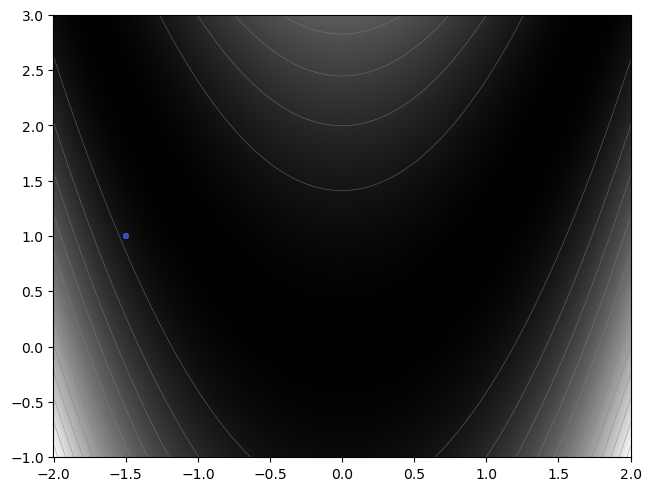

In [18]:
bench = FunctionDescent('rosen')
opt = FourierPreconditioner(bench.parameters(),  1e-3,)
bench.run(opt, 1000,)
bench.plot_solution()

In [ ]:
bench.render_video('eveoe')

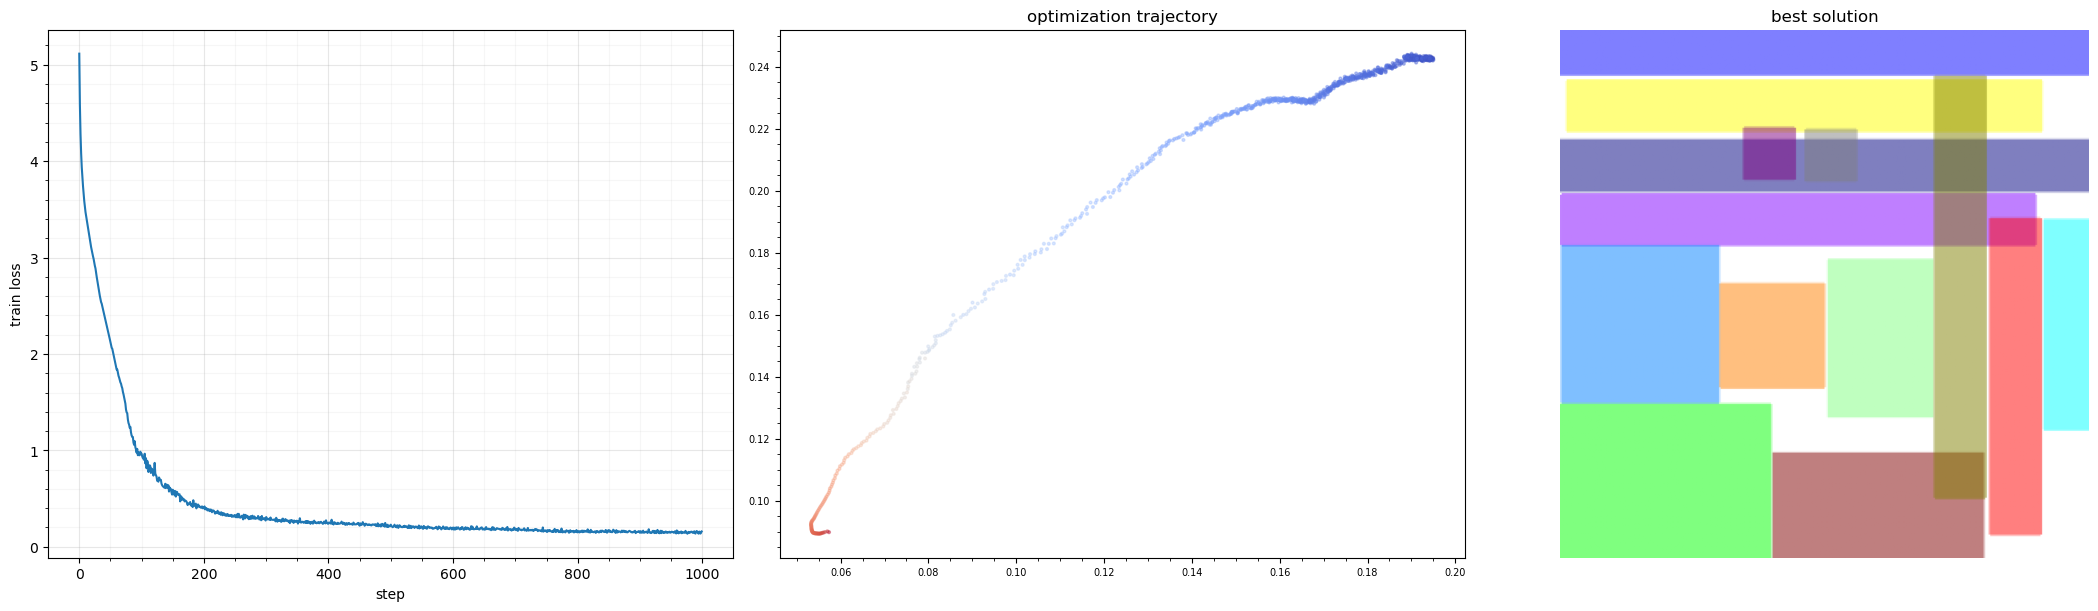

In [22]:
bench = BoxPacking()
opt = FourierPreconditioner(bench.parameters(), 1e-2)
bench.run(opt, 1000)
bench.plot_summary(1, fig=Fig().figsize(24, 6))

In [23]:
bench.render_video('FourierPreconditioner')

1000/1000 | 11.21s               


image.shape = torch.Size([3, 229, 229]), image.numel() = 157323


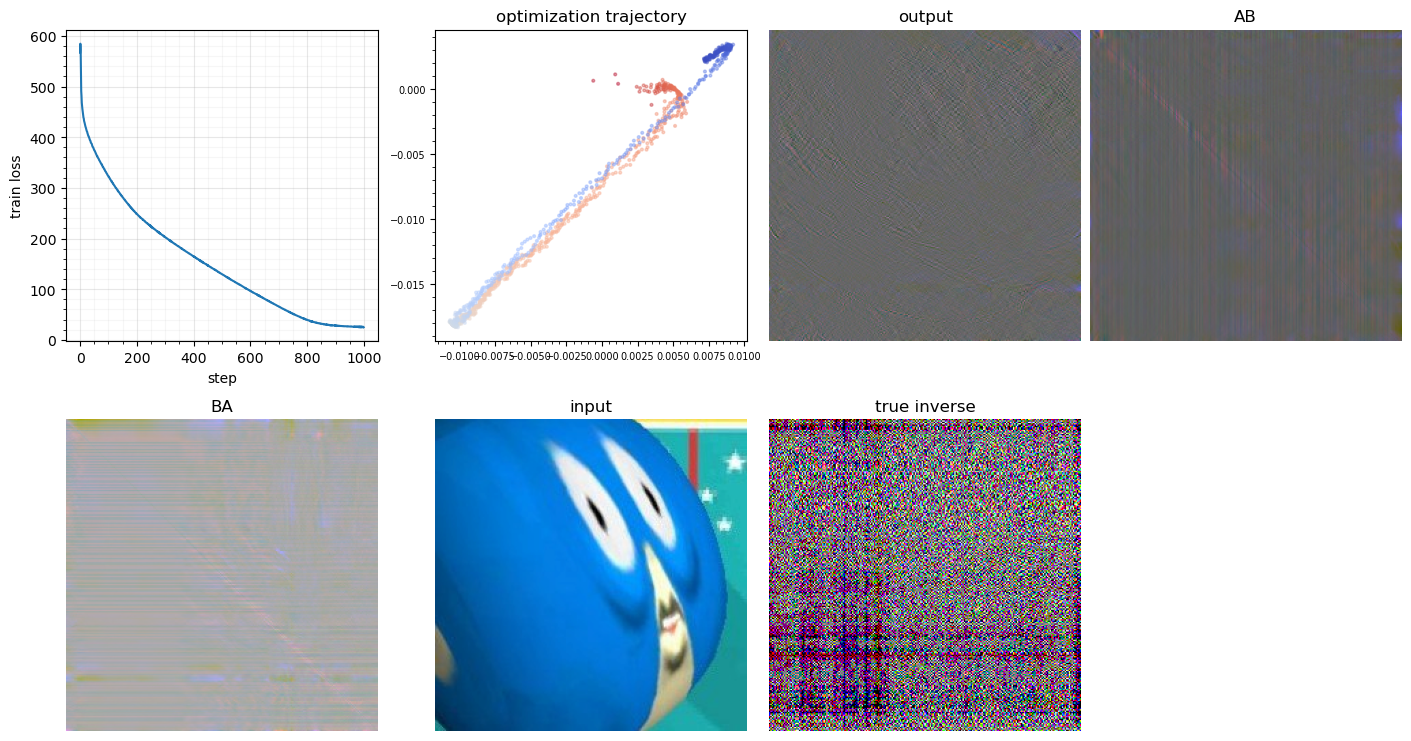

In [30]:
REDUCTION = 0
BW = False

image = znormalize(imreadtensor('/var/mnt/ssd/Файлы/Изображения/Сохраненное/sanic.jpg').float())
if REDUCTION > 1:
    image = image[:,::REDUCTION,::REDUCTION].clone()
if BW: image = image.mean(0)

print(f'{image.shape = }, {image.numel() = }')
bench = MatrixInverse(image)
opt = FourierPreconditioner(bench.parameters(), 3e-1)
bench.run(opt, 1000)
bench.plot_summary()

In [ ]:
bench.render_video('glesgd inv', scale=4)

In [ ]:
clean_mem()
bench = MNIST1D(
    ResNet18(1, 8, 10, 1),
    loss = F.cross_entropy,
    batch_size = 32,
    test_batch_size = None,
).cuda()

opt = sig(FourierPreconditioner, bench.parameters(), 1e-2)

bench.run(
    opt,
    max_time = 60,
    test_every_sec = 1,
    name = None
)

bench.save_run('MNIST1d-32 runs')
bench.plot_summary()

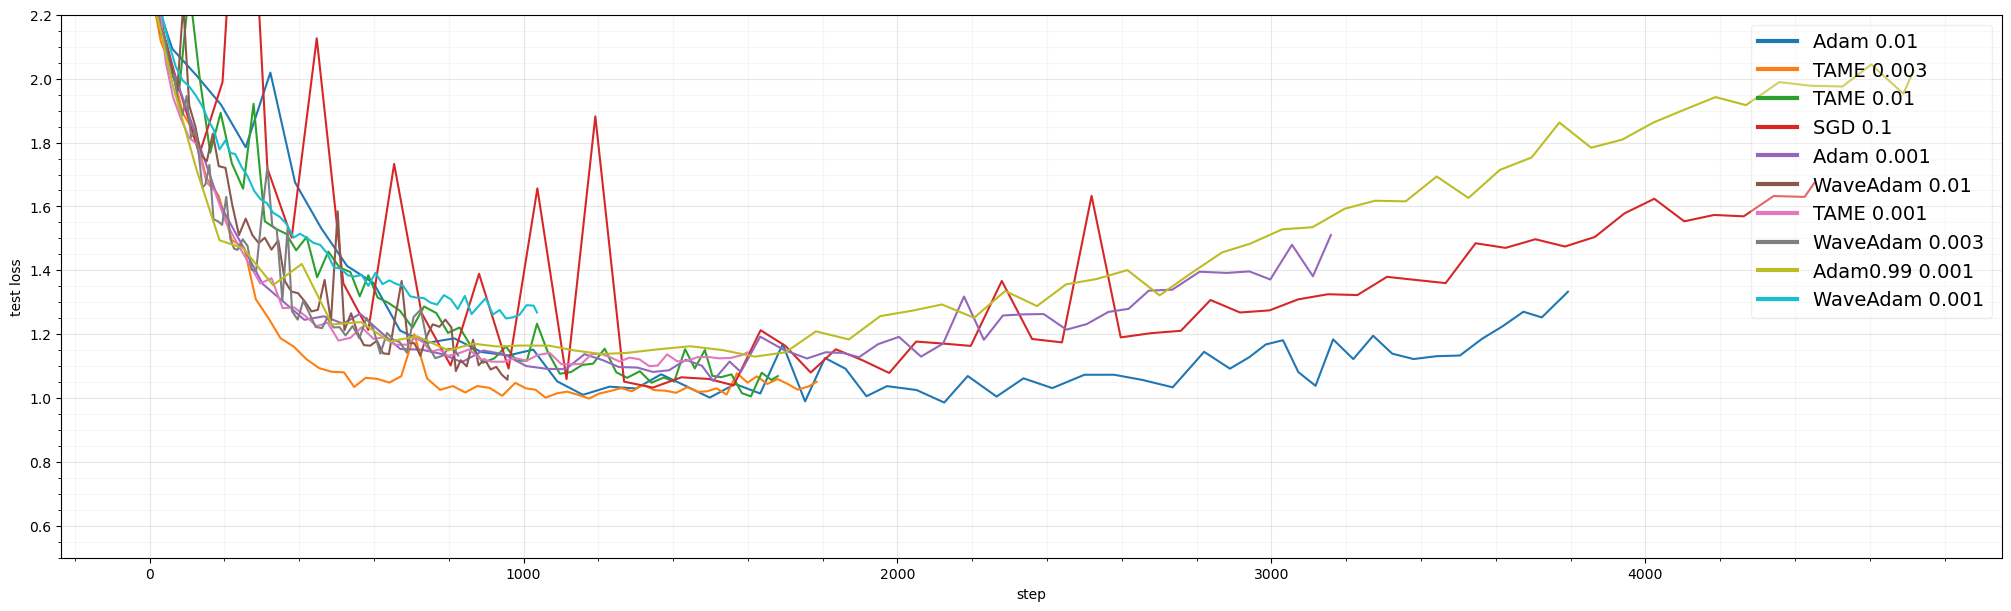

In [15]:
s = Summary.from_runs_dir('MNIST1d-32 runs')
(
s
.map_name('name', 'optimizer/lr')
.sorted_by_metric('test loss', 'min')
.comparison
.plot('test loss', highest=False)
.ylim(0.5, 2.2)
.legend(size=14, loc='upper right')
.figsize(20, 6)
.show()
)

In [76]:
s = Summary.from_runs_dir('MNIST1d-32 runs')

import polars as pl
pl.Config.set_tbl_rows(100)
s.map_name('name', 'optimizer/lr').sorted_by_metric('test loss', 'min').to_polars('name', 'logger/test loss/min', 'attrs/current_step')

name,logger/test loss/min,attrs/current_step
str,f32,i64
"""Adam 0.01""",0.985916,3793
"""TAME 0.003""",0.998399,1784
"""TAME 0.01""",1.00513,1680
"""SGD 0.1""",1.032747,4452
"""Adam 0.001""",1.053944,3159
"""TAME 0.001""",1.099992,1599
"""TAME 0.1""",1.413156,1824
"""Adam 0.1""",1.453821,3408
"""StochasticPowellOptimizer None""",1.552979,6649


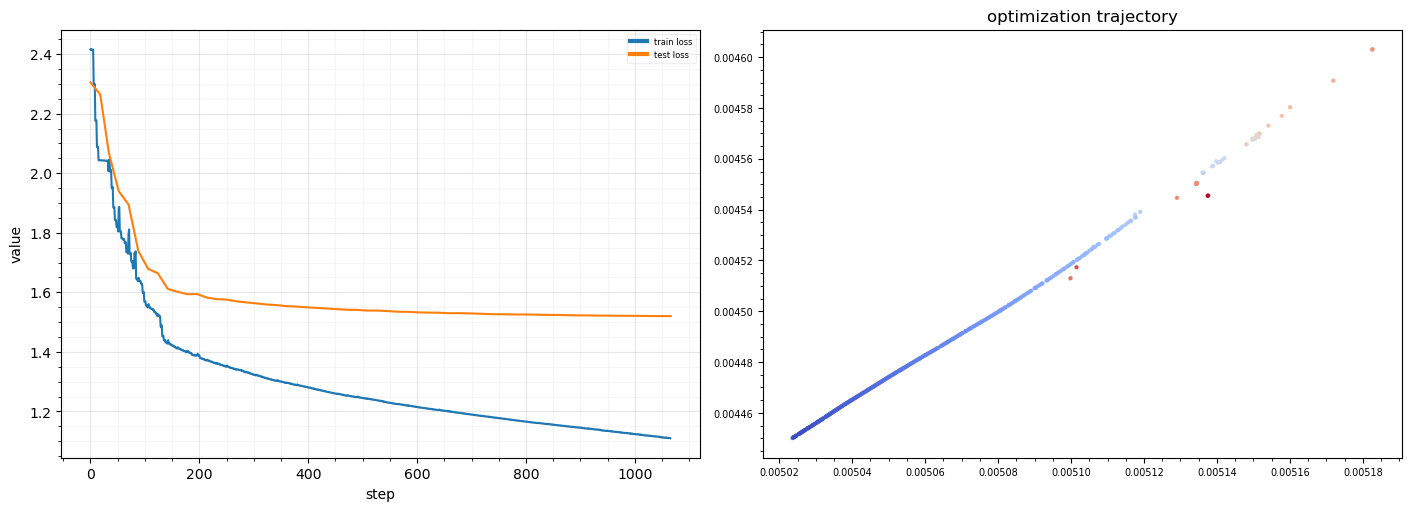

In [200]:
clean_mem()
bench = MNIST1D(
    ResNet18(1, 8, 10, 1),
    loss = F.cross_entropy,
    batch_size = None,
    test_batch_size = None,
)

opt = sig(NonPolyOptimizer, bench.parameters())

bench.run(
    opt,
    max_time = 60,
    test_every_sec = 1,
    name = None,
)

bench.save_run('MNIST1d-fullbatch runs')
bench.plot_summary()

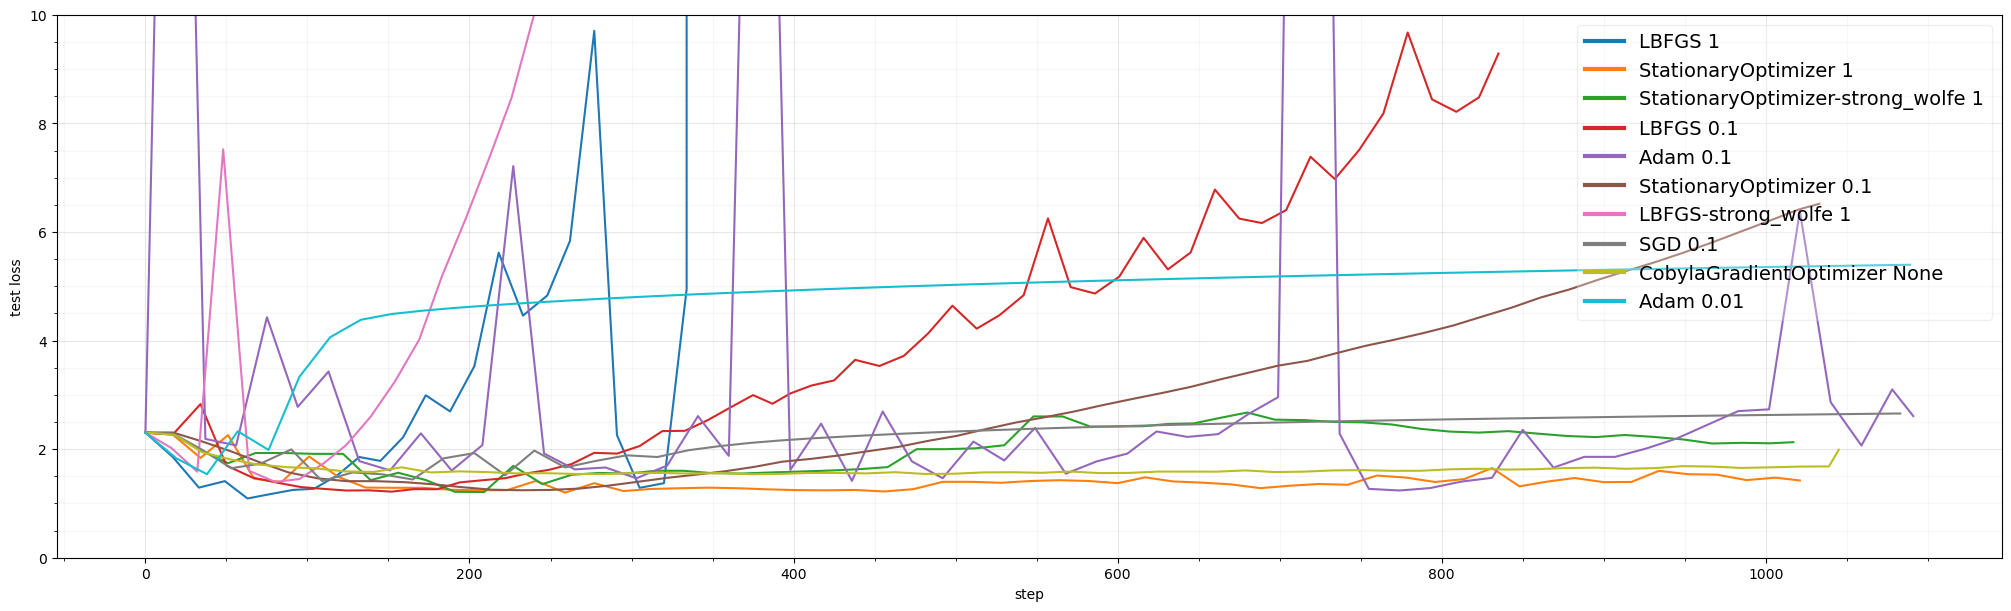

In [73]:
s = Summary.from_runs_dir('MNIST1d-fullbatch runs')
(
s
.map_name('name', 'optimizer/lr')
.sorted_by_metric('test loss', 'min')
.comparison
.plot('test loss', highest=False)
.ylim(0.0, 10)
.legend(size=14, loc='upper right')
.figsize(20, 6)
.show()
)

In [8]:
s = Summary.from_runs_dir('MNIST1d-fullbatch runs')

import polars as pl
pl.Config.set_tbl_rows(100)
s.map_name('name', 'optimizer/lr').sorted_by_metric('test loss', 'min').to_polars('name', 'logger/test loss/min', 'attrs/current_step')

name,logger/test loss/min,attrs/current_step
str,f32,i64
"""LBFGS 1""",1.091433,833
"""StationaryOptimizer 1""",1.199481,1021
"""StationaryOptimizer-strong_wol…",1.209188,1017
"""LBFGS 0.1""",1.21727,835
"""Adam 0.1""",1.238158,1091
"""StationaryOptimizer 0.1""",1.242848,1033
"""LBFGS-strong_wolfe 1""",1.396248,979
"""SGD 0.1""",1.413328,1083
"""Adam 0.01""",1.53852,1089
